# Notes
- Currently the first three games of each season are cut off

# Premier League Match Predictor: A Machine Learning Approach

## Project Overview
This project aims to create a machine learning model to predict the outcomes of Premier League football matches using historical data. The model utilizes various features including team performance metrics, league positions, and match-specific details to make predictions.


## Data Collection and Preprocessing

### Importing Required Libraries

In [1]:
import aiohttp
import asyncio
import pandas as pd
from understat import Understat
import json
import nest_asyncio
from mplsoccer import Pitch, VerticalPitch
import matplotlib.pyplot as plt
import random
import numpy as np

nest_asyncio.apply()

### Setting Up the Data Range

In [2]:
YEARS = [2019, 2020, 2021,2022, 2023,2024]

TEST_DATE = '2024-01-01'



### Fetching Match Results from Understat


In [3]:
async def match_results(years):
    async with aiohttp.ClientSession() as session:
        understat = Understat(session)
        fixtures = []
        for year in years:
            year_fixtures = await understat.get_league_results("epl", year)
            fixtures.extend(year_fixtures)
    return fixtures


loop = asyncio.get_event_loop()
fixtures = loop.run_until_complete(match_results(YEARS))

results_df = pd.json_normalize(fixtures)

results_df.head()


,id,isResult,datetime,h.id,h.title,h.short_title,a.id,a.title,a.short_title,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l
0,11643,True,2019-08-09 20:00:00,87,Liverpool,LIV,79,Norwich,NOR,4,1,2.23456,0.842407,0.7377,0.1732,0.0891
1,11644,True,2019-08-10 12:30:00,81,West Ham,WHU,88,Manchester City,MCI,0,5,1.2003,3.18377,0.0452,0.1166,0.8382
2,11645,True,2019-08-10 15:00:00,73,Bournemouth,BOU,238,Sheffield United,SHE,1,1,1.34099,1.59864,0.2083,0.3923,0.3994
3,11646,True,2019-08-10 15:00:00,92,Burnley,BUR,74,Southampton,SOU,3,0,0.909241,1.08752,0.266,0.3442,0.3898
4,11647,True,2019-08-10 15:00:00,78,Crystal Palace,CRY,72,Everton,EVE,0,0,0.87159,1.2246,0.2427,0.3231,0.4342


## Data Exploration and Feature Engineering

### Creating Team ID to Name Mapping

In [4]:
print(results_df['h.id'].unique())
print(results_df['h.title'].unique())

team_names = {}
i = 0
for ids in results_df['h.id'].unique():
    team_names[int(ids)] = results_df['h.title'].unique()[i]

    i+= 1

['87' '81' '73' '92' '78' '90' '82' '86' '75' '89' '83' '71' '220' '72'
 '79' '74' '88' '238' '80' '229' '228' '76' '245' '244' '249' '256' '285']
['Liverpool' 'West Ham' 'Bournemouth' 'Burnley' 'Crystal Palace' 'Watford'
 'Tottenham' 'Newcastle United' 'Leicester' 'Manchester United' 'Arsenal'
 'Aston Villa' 'Brighton' 'Everton' 'Norwich' 'Southampton'
 'Manchester City' 'Sheffield United' 'Chelsea' 'Wolverhampton Wanderers'
 'Fulham' 'West Bromwich Albion' 'Leeds' 'Brentford' 'Nottingham Forest'
 'Luton' 'Ipswich']


### Analyzing Dataset Characteristics

In [5]:
# There should be 380 games in a premier league season
print("Number of games in a premier league season: ", len(results_df.id))

# Number of unique teams in the premier league
print("Number of unique teams in the premier league: ", len(results_df['a.title'].unique()))

Number of games in a premier league season:  1979
Number of unique teams in the premier league:  27


### Data Type Conversion and Feature Creation

In [6]:
results_df.dtypes

id               object
isResult           bool
datetime         object
h.id             object
h.title          object
h.short_title    object
a.id             object
a.title          object
a.short_title    object
goals.h          object
goals.a          object
xG.h             object
xG.a             object
forecast.w       object
forecast.d       object
forecast.l       object
dtype: object

### Turn the ids into integers


In [7]:
results_df[['h.id', 'a.id']] = results_df[['h.id', 'a.id']].astype(int)


### Turn the datetime into a datetime object and create new columns for the time, hour and day of the week


In [8]:
results_df['datetime'] = pd.to_datetime(results_df['datetime'])

results_df['time'] = results_df['datetime'].dt.time

results_df['hour'] = results_df['datetime'].dt.hour

results_df['day'] = results_df['datetime'].dt.day_of_week

results_df[['datetime', 'time', 'hour', 'day']]


,datetime,time,hour,day
0,2019-08-09 20:00:00,20:00:00,20,4
1,2019-08-10 12:30:00,12:30:00,12,5
2,2019-08-10 15:00:00,15:00:00,15,5
3,2019-08-10 15:00:00,15:00:00,15,5
4,2019-08-10 15:00:00,15:00:00,15,5
...,...,...,...,...
1974,2024-10-19 14:00:00,14:00:00,14,5
1975,2024-10-19 14:00:00,14:00:00,14,5
1976,2024-10-19 16:30:00,16:30:00,16,5
1977,2024-10-20 13:00:00,13:00:00,13,6


## Create a target column which is 2 if home team wins, 1 if draw and 0 if away team wins


In [9]:
results_df['target'] = results_df.apply(lambda row: 2 if row['goals.h'] > row['goals.a'] else (1 if row['goals.h'] == row['goals.a'] else 0), axis=1)

results_df.head()

,id,isResult,datetime,h.id,h.title,h.short_title,a.id,a.title,a.short_title,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l,time,hour,day,target
0,11643,True,2019-08-09 20:00:00,87,Liverpool,LIV,79,Norwich,NOR,4,1,2.23456,0.842407,0.7377,0.1732,0.0891,20:00:00,20,4,2
1,11644,True,2019-08-10 12:30:00,81,West Ham,WHU,88,Manchester City,MCI,0,5,1.2003,3.18377,0.0452,0.1166,0.8382,12:30:00,12,5,0
2,11645,True,2019-08-10 15:00:00,73,Bournemouth,BOU,238,Sheffield United,SHE,1,1,1.34099,1.59864,0.2083,0.3923,0.3994,15:00:00,15,5,1
3,11646,True,2019-08-10 15:00:00,92,Burnley,BUR,74,Southampton,SOU,3,0,0.909241,1.08752,0.266,0.3442,0.3898,15:00:00,15,5,2
4,11647,True,2019-08-10 15:00:00,78,Crystal Palace,CRY,72,Everton,EVE,0,0,0.87159,1.2246,0.2427,0.3231,0.4342,15:00:00,15,5,1


## Can now create a basic random forest model to predict results using the hour, day, home team id and away team id


In [10]:
from sklearn.ensemble import RandomForestClassifier


In [11]:
rf = RandomForestClassifier(n_estimators=10000, random_state=12, min_samples_split=15)


## Use data up to 2024-02-01 to train the model and test on data from 2024-02-01 onwards


In [12]:
train = results_df[results_df['datetime'] < TEST_DATE]
test = results_df[results_df['datetime'] >= TEST_DATE]

predictors = ['hour', 'day', 'h.id', 'a.id']

rf.fit(train[predictors], train['target'])

RandomForestClassifier(min_samples_split=15, n_estimators=10000,
                       random_state=12)

In [13]:
from sklearn.metrics import accuracy_score


In [14]:
preds = rf.predict(test[predictors])

acc = accuracy_score(test['target'], preds)

acc

0.5095057034220533

## This model is not very accurate but is better than random guessing.
### We can use more data to create a more sophisticated model


In [15]:
# # Reshape the DataFrame to have a single column for team ids and include a specifier for home/away
# melted_df = results_df.melt(id_vars=['id', 'isResult', 'datetime', 'goals.h', 'goals.a', 'xG.h', 'xG.a', 'forecast.w', 'forecast.d', 'forecast.l', 'target', 'time', 'hour', 'day'],
#                             value_vars=['h.id', 'a.id'],
#                             var_name='home_away', value_name='team_id')

# # Group by the team_id
# grouped_matches = {team_id: group for team_id, group in melted_df.groupby('team_id')}

# # Sort each group's DataFrame by date and reset the index
# for team_id, group in grouped_matches.items():
#     grouped_matches[team_id] = group.sort_values(by='datetime').reset_index(drop=True)

# grouped_matches[83].head()



## We can create a new dataset which contains addiotnal information

In [16]:
melted_df = results_df.melt(id_vars=['id', 'isResult', 'datetime', 'goals.h', 'goals.a', 'xG.h', 'xG.a', 'forecast.w', 'forecast.d', 'forecast.l', 'target', 'time', 'hour', 'day'],
                            value_vars=['h.id', 'a.id'],
                            var_name='home_away', value_name='team_id')

# Merge melted_df with the original results_df to get h.id and a.id columns
melted_df = melted_df.merge(results_df[['id', 'h.id', 'a.id']], on='id')

# Create new columns to reflect the perspective of the grouped team
melted_df['goals_for'] = melted_df.apply(lambda row: row['goals.h'] if row['home_away'] == 'h.id' else row['goals.a'], axis=1)
melted_df['goals_against'] = melted_df.apply(lambda row: row['goals.a'] if row['home_away'] == 'h.id' else row['goals.h'], axis=1)
melted_df['xG_for'] = melted_df.apply(lambda row: row['xG.h'] if row['home_away'] == 'h.id' else row['xG.a'], axis=1)
melted_df['xG_against'] = melted_df.apply(lambda row: row['xG.a'] if row['home_away'] == 'h.id' else row['xG.h'], axis=1)
melted_df['is_home'] = melted_df['home_away'] == 'h.id'
melted_df['true_target'] = melted_df.apply(lambda row: row['target'] if row['is_home'] == True else 2 if row['target'] == 0 else 0 if row['target'] == 2 else 1, axis=1)

# Add opposition team ID
melted_df['opposition_team_id'] = melted_df.apply(lambda row: row['a.id'] if row['home_away'] == 'h.id' else row['h.id'], axis=1)

# Group by the team_id8
grouped_matches = {team_id: group for team_id, group in melted_df.groupby('team_id')}

# Sort each group's DataFrame by date and reset the index
for team_id, group in grouped_matches.items():
    grouped_matches[team_id] = group.sort_values(by='datetime').reset_index(drop=True)

grouped_matches[83].head()

,id,isResult,datetime,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l,...,team_id,h.id,a.id,goals_for,goals_against,xG_for,xG_against,is_home,true_target,opposition_team_id
0,11650,True,2019-08-11 14:00:00,0,1,0.380551,1.13309,0.1052,0.3057,0.5891,...,83,86,83,1,0,1.13309,0.380551,False,2,86
1,11653,True,2019-08-17 12:30:00,2,1,1.1644,1.39172,0.2899,0.2836,0.4265,...,83,83,92,2,1,1.1644,1.39172,True,2,92
2,11670,True,2019-08-24 17:30:00,3,1,2.78821,0.985542,0.7948,0.1361,0.0691,...,83,87,83,1,3,0.985542,2.78821,False,0,87
3,11682,True,2019-09-01 16:30:00,2,2,1.92509,1.95514,0.3461,0.2536,0.4003,...,83,83,82,2,2,1.92509,1.95514,True,1,82
4,11691,True,2019-09-15 15:30:00,2,2,2.83209,1.00616,0.8062,0.1365,0.0573,...,83,90,83,2,2,1.00616,2.83209,False,1,90


## Create rolling averages for the number of goals scored and conceded, and the number of xG scored and conceded


In [17]:
def rolling_averages(group, cols, new_cols, window):
    rolling_states = group[cols].rolling(window=window, closed='left').mean()
    group[new_cols] = rolling_states
    group = group.dropna(subset=new_cols)
    
    return group

In [18]:
cols = ["goals_for", "goals_against", 'xG_for', 'xG_against', 'true_target']
new_cols = [f"{col}_rolling" for col in cols]


In [19]:
rolling_averages(grouped_matches[83], cols, new_cols, 3).head()


,id,isResult,datetime,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l,...,xG_for,xG_against,is_home,true_target,opposition_team_id,goals_for_rolling,goals_against_rolling,xG_for_rolling,xG_against_rolling,true_target_rolling
3,11682,True,2019-09-01 16:30:00,2,2,1.92509,1.95514,0.3461,0.2536,0.4003,...,1.92509,1.95514,True,1,82,1.333333,1.333333,1.094344,1.520160,1.333333
4,11691,True,2019-09-15 15:30:00,2,2,2.83209,1.00616,0.8062,0.1365,0.0573,...,1.00616,2.83209,False,1,90,1.666667,2.000000,1.358344,2.045023,1.000000
5,11702,True,2019-09-22 15:30:00,3,2,2.53209,1.71546,0.5722,0.2195,0.2083,...,2.53209,1.71546,True,2,71,1.666667,2.333333,1.305597,2.525147,0.666667
6,11712,True,2019-09-30 19:00:00,1,1,1.1335,1.70399,0.2214,0.2554,0.5232,...,1.70399,1.1335,False,1,89,2.333333,2.000000,1.821113,2.167563,1.333333
7,11722,True,2019-10-06 14:00:00,1,0,1.24109,0.683967,0.5216,0.3114,0.167,...,1.24109,0.683967,True,2,73,2.000000,1.666667,1.747413,1.893683,1.333333


## Bringing all these grouped results into one dataframe

In [20]:
# Apply rolling averages to each group and concatenate the results
matches_rolling = pd.concat(
    [rolling_averages(group, cols, new_cols, 3) for group in grouped_matches.values()],
    ignore_index=True
)

# Group by team_id
grouped_by_team = matches_rolling.groupby('team_id')

grouped_by_team.head()

# # Example: Access the group for a specific team_id
# example_team_id = 83
# example_team_group = grouped_by_team.get_group(example_team_id)



,id,isResult,datetime,goals.h,goals.a,xG.h,xG.a,forecast.w,forecast.d,forecast.l,...,xG_for,xG_against,is_home,true_target,opposition_team_id,goals_for_rolling,goals_against_rolling,xG_for_rolling,xG_against_rolling,true_target_rolling
0,11676,True,2019-08-31 15:00:00,1,0,1.41394,0.30354,0.6771,0.2444,0.0785,...,0.30354,1.41394,False,0,78,1.333333,1.666667,1.048738,1.819023,0.666667
1,11692,True,2019-09-16 19:00:00,0,0,1.40502,0.535279,0.6373,0.2496,0.1131,...,1.40502,0.535279,True,1,81,1.000000,1.000000,0.936719,1.432797,0.666667
2,11702,True,2019-09-22 15:30:00,3,2,2.53209,1.71546,0.5722,0.2195,0.2083,...,1.71546,2.53209,False,0,83,0.666667,0.333333,0.854829,1.068633,1.000000
3,11706,True,2019-09-28 14:00:00,2,2,0.914266,1.66919,0.1745,0.2428,0.5827,...,0.914266,1.66919,True,1,92,0.666667,1.333333,1.141340,1.493770,0.333333
4,11717,True,2019-10-05 15:00:00,1,5,1.84838,3.67827,0.0918,0.1263,0.7819,...,3.67827,1.84838,False,2,79,1.333333,1.666667,1.344915,1.578853,0.666667
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3872,26633,True,2024-09-14 14:00:00,0,0,1.75696,0.721323,0.6638,0.2448,0.0914,...,0.721323,1.75696,False,1,220,0.666667,2.333333,0.509883,2.732023,0.333333
3873,26643,True,2024-09-21 14:00:00,1,1,2.89813,1.645,0.6951,0.1778,0.1271,...,1.645,2.89813,False,1,74,0.666667,1.666667,0.636123,2.007990,0.666667
3874,26659,True,2024-09-29 13:00:00,2,2,1.84608,1.14494,0.5579,0.2508,0.1913,...,1.84608,1.14494,True,1,71,0.666667,0.666667,1.024457,1.947973,1.000000
3875,26665,True,2024-10-05 14:00:00,4,1,4.39402,1.18463,0.9499,0.0394,0.0107,...,1.18463,4.39402,False,0,81,1.000000,1.000000,1.404134,1.933343,1.000000


In [21]:
matches_rolling.columns

Index(['id', 'isResult', 'datetime', 'goals.h', 'goals.a', 'xG.h', 'xG.a',
       'forecast.w', 'forecast.d', 'forecast.l', 'target', 'time', 'hour',
       'day', 'home_away', 'team_id', 'h.id', 'a.id', 'goals_for',
       'goals_against', 'xG_for', 'xG_against', 'is_home', 'true_target',
       'opposition_team_id', 'goals_for_rolling', 'goals_against_rolling',
       'xG_for_rolling', 'xG_against_rolling', 'true_target_rolling'],
      dtype='object')

### Reset the index so that it is a simple list of rows


In [22]:
matches_rolling.index = range(matches_rolling.shape[0])

In [23]:
def make_predictions(data, predictors):
    train = data[data['datetime'] < TEST_DATE]
    test = data[data['datetime'] >= TEST_DATE]

    rf.fit(train[predictors], train['true_target'])
    preds = rf.predict(test[predictors])
    combined = pd.DataFrame(dict(actual=test['true_target'], predicted=preds,), index=test.index)
    acc = accuracy_score(test['true_target'], preds)
    # precision = precision_score(test['true_target'], preds)
    precision = 0

    return acc, precision


In [24]:
matches_rolling.columns

Index(['id', 'isResult', 'datetime', 'goals.h', 'goals.a', 'xG.h', 'xG.a',
       'forecast.w', 'forecast.d', 'forecast.l', 'target', 'time', 'hour',
       'day', 'home_away', 'team_id', 'h.id', 'a.id', 'goals_for',
       'goals_against', 'xG_for', 'xG_against', 'is_home', 'true_target',
       'opposition_team_id', 'goals_for_rolling', 'goals_against_rolling',
       'xG_for_rolling', 'xG_against_rolling', 'true_target_rolling'],
      dtype='object')

## Now create a new tree based model to predict the results with more features


In [25]:
predictors = ['goals_for_rolling', 'goals_against_rolling', 'xG_for_rolling', 'xG_against_rolling', 'hour', 'day', 'is_home', 'opposition_team_id', 'id', 'true_target_rolling']

acc, precision = make_predictions(matches_rolling, predictors)

acc

0.5124282982791587

## The different features used going forward will be:
- id
- opposition id
- current league position
- current form (last 5 games)
- current xG for and against
- current goals for and against
- oppositon league position
- hour
- is_home
- days since last game

['id', 'isResult', 'datetime', 'goals.h', 'goals.a', 'xG.h', 'xG.a',
       'forecast.w', 'forecast.d', 'forecast.l', 'target', 'time', 'hour',
       'day', 'home_away', 'team_id', 'h.id', 'a.id', 'goals_for',
       'goals_against', 'xG_for', 'xG_against', 'is_home', 'true_target',
       'opposition_team_id', 'goals_for_rolling', 'goals_against_rolling',
       'xG_for_rolling', 'xG_against_rolling', 'true_target_rolling'],
      dtype='object')

In [26]:
df = melted_df[['id','team_id', 'opposition_team_id', 'is_home', 'datetime', 'hour', 'day', 'xG_for', 'xG_against', 'goals_for', 'goals_against', 'true_target']]


In [27]:
df['date'] = df['datetime'].dt.date
df['date']


C:\Users\hayde\AppData\Local\Temp\ipykernel_40436\1640301452.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['date'] = df['datetime'].dt.date


0       2019-08-09
1       2019-08-10
2       2019-08-10
3       2019-08-10
4       2019-08-10
           ...    
3953    2024-10-19
3954    2024-10-19
3955    2024-10-19
3956    2024-10-20
3957    2024-10-20
Name: date, Length: 3958, dtype: object

In [28]:
df.head()

,id,team_id,opposition_team_id,is_home,datetime,hour,day,xG_for,xG_against,goals_for,goals_against,true_target,date
0,11643,87,79,True,2019-08-09 20:00:00,20,4,2.23456,0.842407,4,1,2,2019-08-09
1,11644,81,88,True,2019-08-10 12:30:00,12,5,1.2003,3.18377,0,5,0,2019-08-10
2,11645,73,238,True,2019-08-10 15:00:00,15,5,1.34099,1.59864,1,1,1,2019-08-10
3,11646,92,74,True,2019-08-10 15:00:00,15,5,0.909241,1.08752,3,0,2,2019-08-10
4,11647,78,72,True,2019-08-10 15:00:00,15,5,0.87159,1.2246,0,0,1,2019-08-10


## Now a data fram of form for each team for every week can be created.
### It will have rolling avergaes for different metrics, league position, time from previous game and form.

In [29]:
list_of_team_ids = df['team_id'].unique()

list_of_team_ids


array([ 87,  81,  73,  92,  78,  90,  82,  86,  75,  89,  83,  71, 220,
        72,  79,  74,  88, 238,  80, 229, 228,  76, 245, 244, 249, 256,
       285])

## To do this we need to create a function which find the position of the team in the league on the day before the match


In [30]:
match_dates = df['datetime'].apply(lambda x: x.date())

match_dates



0       2019-08-09
1       2019-08-10
2       2019-08-10
3       2019-08-10
4       2019-08-10
           ...    
3953    2024-10-19
3954    2024-10-19
3955    2024-10-19
3956    2024-10-20
3957    2024-10-20
Name: datetime, Length: 3958, dtype: object

In [31]:
len(match_dates.unique())

629

In [32]:
team_positions = {}

In [59]:
# end_date = '2024-02-01'

DATES = match_dates.unique()

for date in DATES:

    end_date = str(date - pd.Timedelta(days=1))

    if date < pd.to_datetime('2020-08-01').date():
        year = '2019'
    elif date < pd.to_datetime('2021-08-01').date():
        year = '2020'
    elif date < pd.to_datetime('2022-08-01').date():
        year = '2021'
    elif date < pd.to_datetime('2023-08-01').date():
        year = '2022'
    elif date < pd.to_datetime('2024-08-01').date():
        year = '2023'
    else:
        year = '2024'

    async def main():
        async with aiohttp.ClientSession() as session:
            understat = Understat(session)
            table = await understat.get_league_table("EPL", year ,end_date=end_date)
            return table

    loop = asyncio.get_event_loop()
    table = loop.run_until_complete(main())


    team_positions[date] = {}
    i = 0
    for row in table:
        if i>0:
            if (row[1] != 0) & (row[-1] != 0):
                team_positions[date][row[0]] = [i, (row[-1]-row[7])/row[1]]
            else:
                team_positions[date][row[0]] = [i, 0]

        i += 1



# table_df = pd.DataFrame(table)

# table_df


In [35]:
team_positions.keys()

dict_keys([datetime.date(2019, 8, 9), datetime.date(2019, 8, 10), datetime.date(2019, 8, 11), datetime.date(2019, 8, 17), datetime.date(2019, 8, 18), datetime.date(2019, 8, 19), datetime.date(2019, 8, 23), datetime.date(2019, 8, 24), datetime.date(2019, 8, 25), datetime.date(2019, 8, 31), datetime.date(2019, 9, 1), datetime.date(2019, 9, 14), datetime.date(2019, 9, 15), datetime.date(2019, 9, 16), datetime.date(2019, 9, 20), datetime.date(2019, 9, 21), datetime.date(2019, 9, 22), datetime.date(2019, 9, 28), datetime.date(2019, 9, 29), datetime.date(2019, 9, 30), datetime.date(2019, 10, 5), datetime.date(2019, 10, 6), datetime.date(2019, 10, 19), datetime.date(2019, 10, 20), datetime.date(2019, 10, 21), datetime.date(2019, 10, 25), datetime.date(2019, 10, 26), datetime.date(2019, 10, 27), datetime.date(2019, 11, 2), datetime.date(2019, 11, 3), datetime.date(2019, 11, 8), datetime.date(2019, 11, 9), datetime.date(2019, 11, 10), datetime.date(2019, 11, 23), datetime.date(2019, 11, 24), da

In [37]:
# team_position_test = {}
# DATES = match_dates[5:]

# for date in DATES:

#     # if (date != pd.to_datetime('2022-08-05').date()) & (date != pd.to_datetime('2023-08-11').date()):

#     end_date = str(date - pd.Timedelta(days=1))

#     if date < pd.to_datetime('2023-07-01').date():
#         year = '2022'
#     elif date < pd.to_datetime('2024-07-01').date():
#         year = '2023'
#     else:
#         year = '2024'

#     async def main():
#         async with aiohttp.ClientSession() as session:
#             understat = Understat(session)
#             table = await understat.get_league_table("EPL", year ,end_date=end_date)
#             return table

#     loop = asyncio.get_event_loop()
#     table = loop.run_until_complete(main())


#     team_positions[date] = {}
#     i = 0
#     for row in table:
#         if i>0:
#             if (row[1] != 0) & (row[-1] != 0):
#                 team_position_test[date][row[0]] = [i, (row[-1]-row[7])/row[1]]
#             else:
#                 team_position_test[date][row[0]] = [i, 0]

#         i += 1


In [38]:
# DATES = match_dates

# async def main():
#     async def fetch_team_positions(date):

#         end_date = str(date - pd.Timedelta(days=1))
#         year = '2022' if date < pd.to_datetime('2023-07-01').date() else '2023' if date < pd.to_datetime('2024-07-01').date() else '2024'

#         async with aiohttp.ClientSession() as session:
#             understat = Understat(session)
#             table = await understat.get_league_table("EPL", year, end_date=end_date)
#             return date, table

#     # Gather all tasks
#     tasks = [fetch_team_positions(date) for date in DATES 
#          if (date != pd.to_datetime('2022-08-05').date()) and (date != pd.to_datetime('2023-08-11').date())]

#     # Run all tasks concurrently
#     results = await asyncio.gather(*tasks)

#     # Process results
#     team_position_test = {}
#     for date, table in results:
#         team_position_test[date] = {}
#         for i, row in enumerate(table):
#             if i > 0:
#                 if row[1] != '0' and row[-1] != '0':
#                     team_position_test[date][row[0]] = [i, (float(row[-1]) - float(row[7])) / float(row[1])]
#                 else:
#                     team_position_test[date][row[0]] = [i, 0]

# asyncio.run(main())

## Create functions to retrieve league position and xP difference for a team on a given date


In [49]:
def get_league_position(team_id, date):

    team_name = team_names[team_id]

    try:
        return team_positions[date][team_name][0]
    except:
        return np.nan

In [50]:
def get_average_xp_diff(team_id, date):
    team_name = team_names[team_id]
    try:
        return team_positions[date][team_name][1]
    except:
        return np.nan

In [41]:

df.dtypes


id                            object
team_id                        int64
opposition_team_id             int64
is_home                         bool
datetime              datetime64[ns]
hour                           int32
day                            int32
xG_for                        object
xG_against                    object
goals_for                     object
goals_against                 object
true_target                    int64
date                          object
dtype: object

In [42]:
team_positions[pd.to_datetime('2022-08-28').date()]


{'Arsenal': [1, -0.6625000000000001],
 'Manchester City': [2, 0.14500000000000002],
 'Brighton': [3, -0.46499999999999986],
 'Tottenham': [4, -0.4833333333333334],
 'Leeds': [5, -0.09250000000000003],
 'Chelsea': [6, -0.375],
 'Manchester United': [7, -0.21750000000000003],
 'Liverpool': [8, 0.7475],
 'Brentford': [9, 0.24249999999999994],
 'Newcastle United': [10, -0.5166666666666666],
 'Fulham': [11, -0.0625],
 'Nottingham Forest': [12, -0.49666666666666676],
 'Crystal Palace': [13, 0.22750000000000004],
 'Southampton': [14, 0.23750000000000004],
 'Aston Villa': [15, 0.22999999999999998],
 'Bournemouth': [16, -0.2825],
 'Everton': [17, 0.38249999999999995],
 'Wolverhampton Wanderers': [18, 0.7966666666666667],
 'Leicester': [19, 0.485],
 'West Ham': [20, 0.6833333333333332]}

In [60]:
df.loc[:, 'position'] = df.apply(lambda x: get_league_position(x['team_id'], x['date']), axis=1)
df.loc[:, 'opp_position'] = df.apply(lambda x: get_league_position(x['opposition_team_id'], x['date']), axis=1)
df.loc[:, 'xp_diff'] = df.apply(lambda x: get_average_xp_diff(x['team_id'], x['date']), axis=1)
df.loc[:, 'opp_xp_diff'] = df.apply(lambda x: get_average_xp_diff(x['opposition_team_id'], x['date']), axis=1)



In [62]:
filtered_df = df[df['true_target'] == 2]
filtered_df.head()


,id,team_id,opposition_team_id,is_home,datetime,hour,day,xG_for,xG_against,goals_for,goals_against,true_target,date,position,opp_position,xp_diff,opp_xp_diff
0,11643,87,79,True,2019-08-09 20:00:00,20,4,2.23456,0.842407,4,1,2,2019-08-09,13.0,7.0,0.00,0.00
3,11646,92,74,True,2019-08-10 15:00:00,15,5,0.909241,1.08752,3,0,2,2019-08-10,16.0,5.0,0.00,0.00
6,11649,82,71,True,2019-08-10 17:30:00,17,5,2.57262,0.639599,3,1,2,2019-08-10,10.0,2.0,0.00,0.00
9,11652,89,80,True,2019-08-11 16:30:00,16,6,2.37442,1.09534,4,0,2,2019-08-11,14.0,11.0,0.00,0.00
10,11653,83,92,True,2019-08-17 12:30:00,12,5,1.1644,1.39172,2,1,2,2019-08-17,7.0,4.0,-0.93,-1.86


In [65]:
predictors = ['team_id', 'opposition_team_id', 'is_home', 'hour', 'day',  'position', 'opp_position', 'xp_diff', 'opp_xp_diff']
predictors = ['team_id', 'opposition_team_id', 'is_home',   'position', 'opp_position']

acc, precision = make_predictions(df, predictors)

acc

0.5688976377952756

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import label_binarize

def plot_model_metrics(y_true, y_pred, y_pred_proba, dates, feature_names):
    # Confusion Matrix
    def plot_confusion_matrix(y_true, y_pred):
        cm = confusion_matrix(y_true, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    # Classification Report
    def print_classification_report(y_true, y_pred):
        print(classification_report(y_true, y_pred))

    # ROC Curve
    def plot_roc_curve(y_true, y_pred_proba):
        y_test_bin = label_binarize(y_true, classes=[0, 1, 2])
        n_classes = y_test_bin.shape[1]

        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        for i in range(n_classes):
            fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_pred_proba[:, i])
            roc_auc[i] = auc(fpr[i], tpr[i])

        plt.figure(figsize=(10, 8))
        for i in range(n_classes):
            plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {i}) (AUC = {roc_auc[i]:.2f})')
        
        plt.plot([0, 1], [0, 1], 'k--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver Operating Characteristic (ROC) Curve')
        plt.legend(loc="lower right")
        plt.show()

    # Feature Importance
    def plot_feature_importance(model, feature_names):
        importances = model.feature_importances_
        indices = np.argsort(importances)[::-1]

        plt.figure(figsize=(12, 8))
        plt.title("Feature Importances")
        plt.bar(range(len(importances)), importances[indices])
        plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
        plt.tight_layout()
        plt.show()

    # Performance Over Time
    def plot_performance_over_time(y_true, y_pred, dates):
        correct = (y_true == y_pred).astype(int)
        df_performance = pd.DataFrame({'date': dates, 'correct': correct})
        df_performance = df_performance.set_index('date')
        df_performance = df_performance.resample('W').mean()  # Weekly average

        plt.figure(figsize=(12, 6))
        plt.plot(df_performance.index, df_performance.correct)
        plt.title('Model Performance Over Time')
        plt.xlabel('Date')
        plt.ylabel('Accuracy')
        plt.ylim(0, 1)
        plt.grid(True)
        plt.show()

    # Call all plotting functions
    plot_confusion_matrix(y_true, y_pred)
    print_classification_report(y_true, y_pred)
    plot_roc_curve(y_true, y_pred_proba)
    plot_feature_importance(rf, feature_names)  # Assuming rf is your model
    plot_performance_over_time(y_true, y_pred, dates)

# Example usage:
# plot_model_metrics(y_true, y_pred, y_pred_proba, test['datetime'], feature_names)

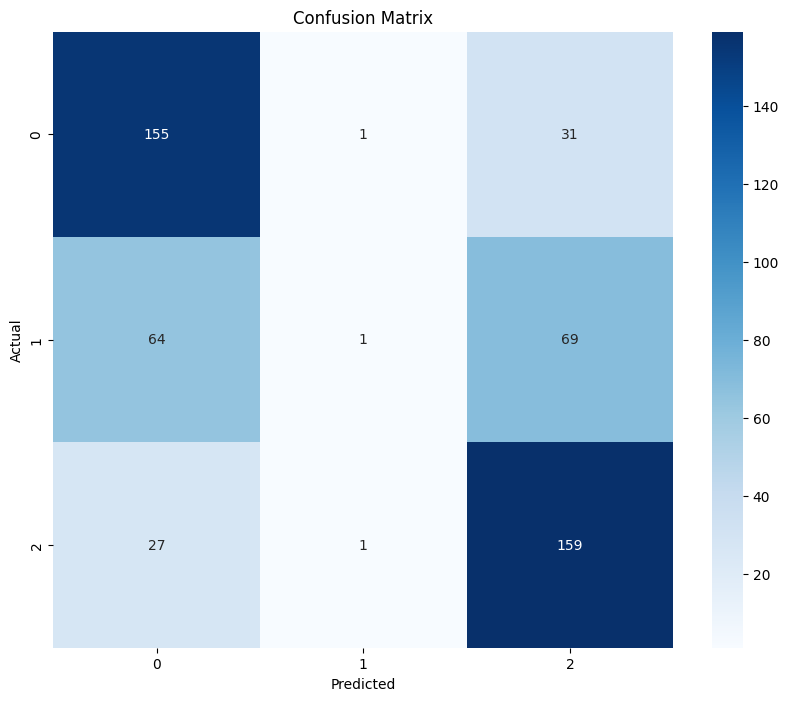

              precision    recall  f1-score   support

           0       0.63      0.83      0.72       187
           1       0.33      0.01      0.01       134
           2       0.61      0.85      0.71       187

    accuracy                           0.62       508
   macro avg       0.53      0.56      0.48       508
weighted avg       0.55      0.62      0.53       508



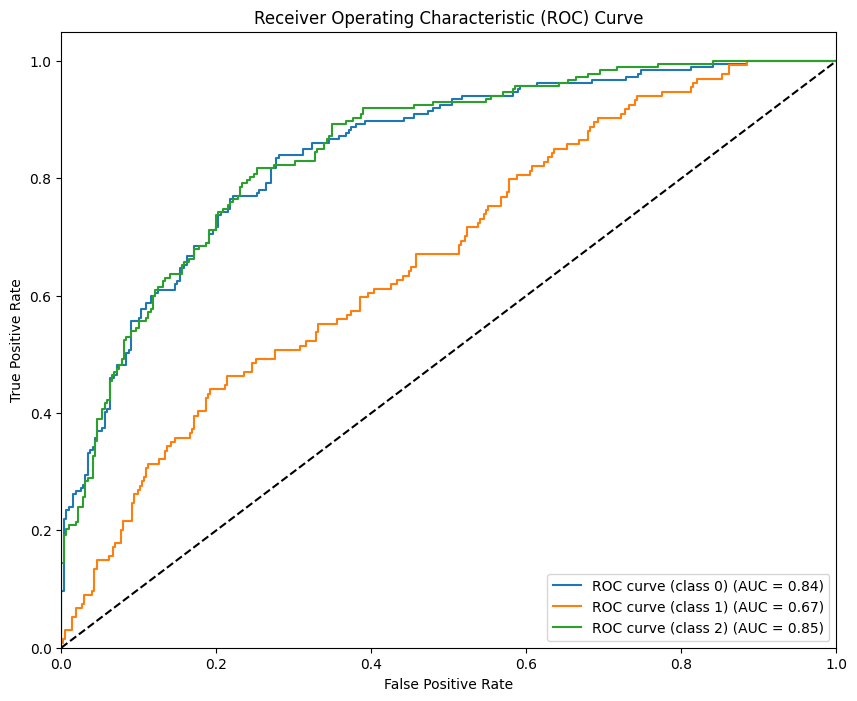

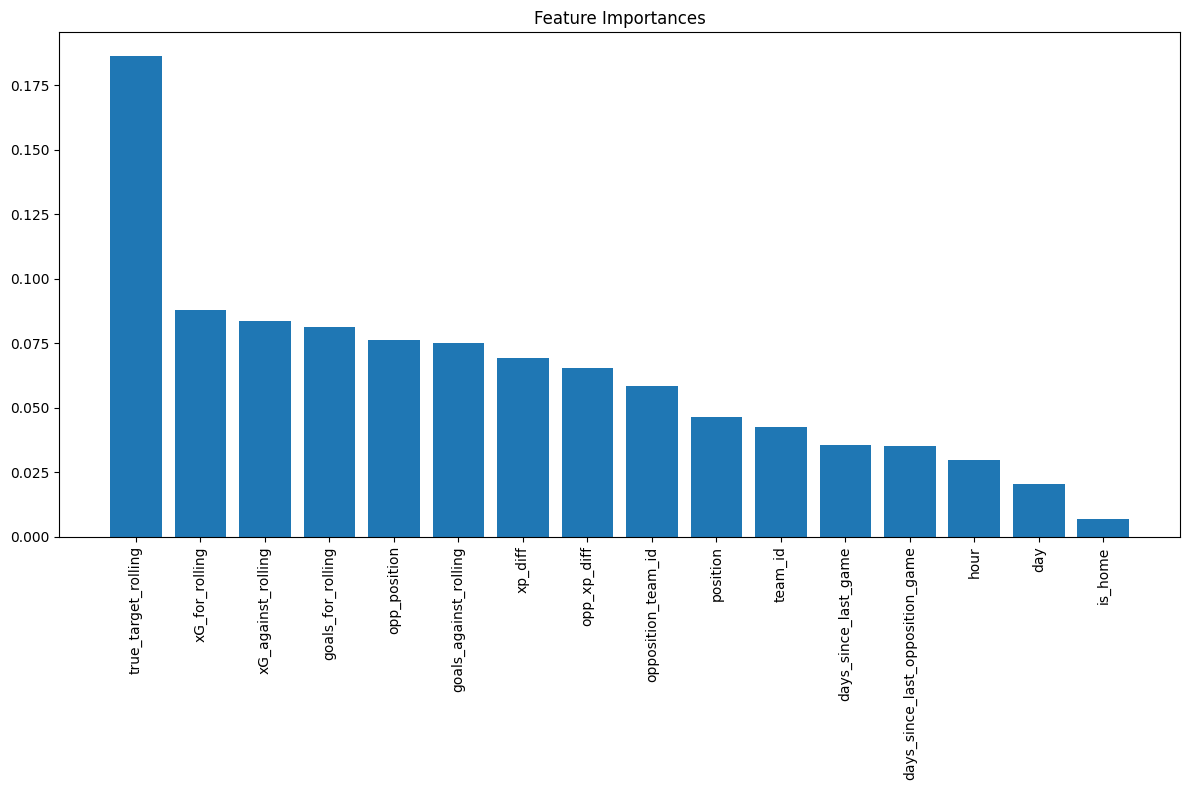

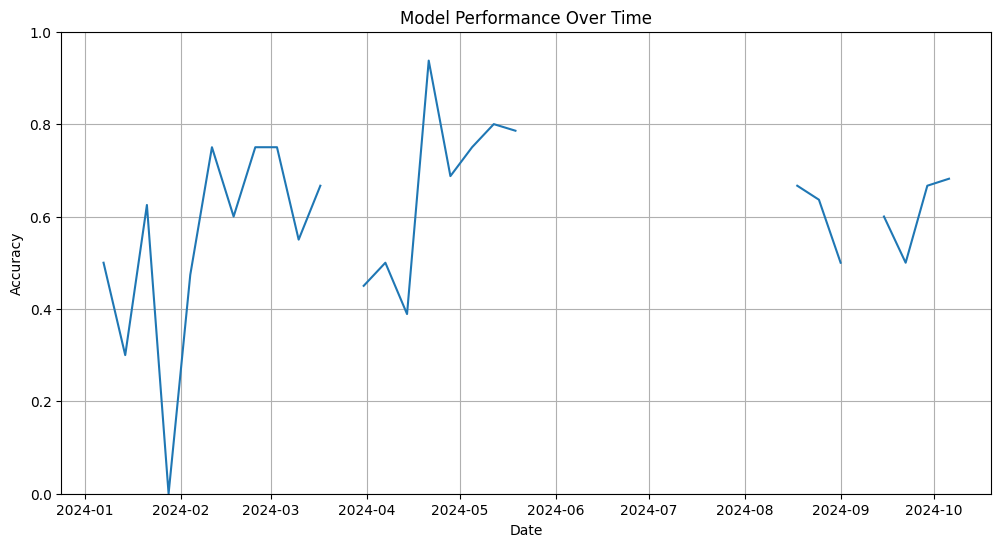

In [74]:
train = df[df['datetime'] < TEST_DATE]
test = df[df['datetime'] >= TEST_DATE]

rf.fit(train[predictors], train['true_target'])
y_pred = rf.predict(test[predictors])
y_true = test['true_target']
y_pred_proba = rf.predict_proba(test[predictors])
feature_names = predictors

plot_model_metrics(y_true, y_pred, y_pred_proba, test['datetime'], feature_names)



## Now cerating rolling avergaes for particular columns and forward filling the NaN values


In [67]:
grouped = df.groupby('team_id')

# Define the columns for which you want to calculate rolling averages
value_columns = ['goals_for', 'goals_against', 'xG_for', 'xG_against', 'true_target']

# Calculate rolling averages for each group and add them as new columns
for col in value_columns:
    # Calculate rolling average with min_periods=1
    df[f'{col}_rolling'] = grouped[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
    
    # Fill NaN values with the next available value (forward fill)
    df[f'{col}_rolling'] = df[f'{col}_rolling'].fillna(method='bfill')

C:\Users\hayde\AppData\Local\Temp\ipykernel_52808\2314375735.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[f'{col}_rolling'] = grouped[col].transform(lambda x: x.rolling(window=5, min_periods=1).mean())
C:\Users\hayde\AppData\Local\Temp\ipykernel_52808\2314375735.py:12: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df[f'{col}_rolling'] = df[f'{col}_rolling'].fillna(method='bfill')
C:\Users\hayde\AppData\Local\Temp\ipykernel_52808\2314375735.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pyda

## Calculate the number of days since the last game


In [68]:
# Ensure the 'datetime' column is in datetime format
df['datetime'] = pd.to_datetime(df['datetime'])

# Sort the dataframe by team_id and datetime
df = df.sort_values(['team_id', 'datetime'])

# Calculate days since previous game for each team
df['days_since_last_game'] = df.groupby('team_id')['datetime'].diff().dt.days

# Fill NaN values for the first game of each team
df['days_since_last_game'] = df['days_since_last_game'].fillna(0)

C:\Users\hayde\AppData\Local\Temp\ipykernel_52808\3519072886.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['datetime'] = pd.to_datetime(df['datetime'])


In [69]:
df= df.sort_values(['opposition_team_id', 'datetime'])

df['days_since_last_opposition_game'] = df.groupby('opposition_team_id')['datetime'].diff().dt.days

df['days_since_last_opposition_game'] = df['days_since_last_opposition_game'].fillna(0)

df = df.sort_values(['team_id', 'datetime'])


In [ ]:
df.head()

In [ ]:
df.dtypes

In [70]:
predictors = ['team_id', 'opposition_team_id', 'is_home', 'hour', 'day',  'position', 'opp_position', 'days_since_last_game', 'xG_for_rolling', 'xG_against_rolling', 'goals_for_rolling', 'goals_against_rolling', 'xp_diff', 'opp_xp_diff', 'days_since_last_opposition_game', 'true_target_rolling']

acc, precision = make_predictions(df, predictors)

acc

0.6200787401574803

In [ ]:
train = df[df['datetime'] < TEST_DATE]
test = df[df['datetime'] >= TEST_DATE]

rf.fit(train[predictors], train['true_target'])
y_pred = rf.predict(test[predictors])
y_true = test['true_target']
y_pred_proba = rf.predict_proba(test[predictors])
feature_names = predictors

plot_model_metrics(y_true, y_pred, y_pred_proba, test['datetime'], feature_names)

In [ ]:
print(df['true_target'].value_counts())

## Now we can add a historical performance between two teams and home and away performance


In [71]:
df['team_id'] = df['team_id'].astype('category')
df['opposition_team_id'] = df['opposition_team_id'].astype('category')

In [72]:
predictors = ['team_id', 'opposition_team_id', 'is_home', 'hour', 'day',  'position', 'opp_position', 'days_since_last_game', 'xG_for_rolling', 'xG_against_rolling', 'goals_for_rolling', 'goals_against_rolling', 'xp_diff', 'opp_xp_diff', 'days_since_last_opposition_game', 'true_target_rolling']

acc, precision = make_predictions(df, predictors)

acc

0.6200787401574803

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

def train_gradient_boosting(train, predictors, target='true_target'):
    gbm = GradientBoostingClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=3,
        random_state=42
    )
    gbm.fit(train[predictors], train[target])
    return gbm

train = df[df['datetime'] < TEST_DATE]
test = df[df['datetime'] >= TEST_DATE]

# Usage
gbm_model = train_gradient_boosting(train, predictors)
gbm_preds = gbm_model.predict(test[predictors])
gbm_acc = accuracy_score(test['true_target'], gbm_preds)
print(f'Gradient Boosting Accuracy: {gbm_acc}')

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

def train_xgboost(train, predictors, target='true_target'):
    model = xgb.XGBClassifier(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )
    model.fit(train[predictors], train[target])
    return model

# Usage
xgb_model = train_xgboost(train, predictors)
xgb_preds = xgb_model.predict(test[predictors])
xgb_acc = accuracy_score(test['true_target'], xgb_preds)
print(f'XGBoost Accuracy: {xgb_acc}')

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import xgboost as xgb
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_xgboost_with_randomsearch(train, test, predictors, target='true_target', n_iter=50):
    """
    Train an XGBoost classifier with hyperparameter tuning using RandomizedSearchCV.

    Parameters:
    - train (DataFrame): Training dataset.
    - test (DataFrame): Test dataset.
    - predictors (list): List of predictor column names.
    - target (str): Name of the target column.
    - n_iter (int): Number of parameter settings sampled.

    Returns:
    - best_xgb (XGBClassifier): Trained XGBoost model with best parameters.
    - random_search (RandomizedSearchCV): RandomizedSearchCV object after fitting.
    """
    
    # Define the parameter distribution for RandomizedSearch
    param_dist = {
        'n_estimators': randint(100, 1000),
        'learning_rate': uniform(0.01, 0.19),
        'max_depth': randint(3, 10),
        'subsample': uniform(0.6, 0.4),
        'colsample_bytree': uniform(0.6, 0.4),
        'gamma': uniform(0, 5),
        'reg_alpha': uniform(0, 1),
        'reg_lambda': uniform(1, 1)
    }

    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
    objective='multi:softprob',
    num_class=3,
    use_label_encoder=False,
    eval_metric='mlogloss',
    scale_pos_weight=0.3,  # Set this to the ratio of classes
    random_state=42
)

    # Initialize RandomizedSearchCV
    random_search = RandomizedSearchCV(
        estimator=xgb_clf,
        param_distributions=param_dist,
        n_iter=n_iter,
        scoring='accuracy',
        cv=5,
        verbose=1,
        random_state=42,
        n_jobs=-1
    )

    # Fit RandomizedSearchCV on the training data
    random_search.fit(train[predictors], train[target])

    # Retrieve the best parameters and estimator
    best_params = random_search.best_params_
    best_xgb = random_search.best_estimator_

    print(f'Best Parameters: {best_params}')

    # Make predictions on the test set
    xgb_preds = best_xgb.predict(test[predictors])

    # Calculate accuracy
    xgb_acc = accuracy_score(test[target], xgb_preds)
    print(f'XGBoost Accuracy: {xgb_acc}')

    # Generate classification report
    print('Classification Report:')
    print(classification_report(test[target], xgb_preds))

    # Plot confusion matrix
    cm = confusion_matrix(test[target], xgb_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('XGBoost Confusion Matrix')
    plt.show()

    return best_xgb, random_search

In [ ]:
# Assuming you have your train and test DataFrames ready
train = df[df['datetime'] < TEST_DATE]  # Example for training data
test = df[df['datetime'] >= TEST_DATE]   # Example for test data
predictors = ['team_id', 'opposition_team_id', 'is_home', 'hour', 'day', 'position', 'opp_position', 'days_since_last_game', 'xG_for_rolling', 'xG_against_rolling', 'goals_for_rolling', 'goals_against_rolling', 'xp_diff', 'opp_xp_diff', 'days_since_last_opposition_game', 'true_target_rolling']

# Train XGBoost with hyperparameter tuning
best_xgb_model, xgb_random = train_xgboost_with_randomsearch(train, test, predictors, target='true_target', n_iter=100)

In [ ]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def train_xgboost_with_gridsearch(train, test, predictors, target='true_target'):
    """
    Train an XGBoost classifier with hyperparameter tuning using GridSearchCV.

    Parameters:
    - train (DataFrame): Training dataset.
    - test (DataFrame): Test dataset.
    - predictors (list): List of predictor column names.
    - target (str): Name of the target column.

    Returns:
    - best_xgb (XGBClassifier): Trained XGBoost model with best parameters.
    - grid_search (GridSearchCV): GridSearchCV object after fitting.
    """
    
    # Define the parameter grid for GridSearchCV
    param_grid = {
        'n_estimators': [100,    500, 1000],
        'learning_rate': [0.01,  0.3],
        'max_depth': [3,  5, 9],
        'min_child_weight': [1,  3, 5],
        'subsample': [0.6,   1.0],
        'colsample_bytree': [0.6,    1.0],
        'gamma': [0, 0.1,  1, 5],
        'reg_alpha': [0.3,  2],
        'reg_lambda': [1,   4]
    }

    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV on the training data
    grid_search.fit(train[predictors], train[target])

    # Retrieve the best parameters and estimator
    best_params = grid_search.best_params_
    best_xgb = grid_search.best_estimator_

    print(f'Best Parameters: {best_params}')

    # Make predictions on the test set
    xgb_preds = best_xgb.predict(test[predictors])

    # Calculate accuracy
    xgb_acc = accuracy_score(test[target], xgb_preds)
    print(f'XGBoost Accuracy: {xgb_acc}')

    # Generate classification report
    print('Classification Report:')
    print(classification_report(test[target], xgb_preds))

    # Plot confusion matrix
    cm = confusion_matrix(test[target], xgb_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('XGBoost Confusion Matrix')
    plt.show()

    return best_xgb, grid_search

# Usage Example
# Assuming you have your train and test DataFrames ready
train = df[df['datetime'] < TEST_DATE]  # Example for training data
test = df[df['datetime'] >= TEST_DATE]   # Example for test data
predictors = ['team_id', 'opposition_team_id', 'is_home', 'hour', 'day', 'position', 'opp_position', 'days_since_last_game', 'xG_for_rolling', 'xG_against_rolling', 'goals_for_rolling', 'goals_against_rolling', 'xp_diff', 'opp_xp_diff', 'days_since_last_opposition_game', 'true_target_rolling']

# Train XGBoost with hyperparameter tuning
best_xgb_model, xgb_grid = train_xgboost_with_gridsearch(train, test, predictors, target='true_target')

In [ ]:
def train_xgboost_with_gridsearch(train, predictors, target='true_target'):
    """
    Train an XGBoost classifier with hyperparameter tuning using GridSearchCV.

    Parameters:
    - train (DataFrame): Training dataset.
    - predictors (list): List of predictor column names.
    - target (str): Name of the target column.

    Returns:
    - best_xgb (XGBClassifier): Trained XGBoost model with best parameters.
    - grid_search (GridSearchCV): GridSearchCV object after fitting.
    """
    import xgboost as xgb
    from sklearn.model_selection import GridSearchCV
    from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
    import seaborn as sns
    import matplotlib.pyplot as plt
    import data_science

    # Define the parameter grid for XGBoost
    param_grid = {
        'n_estimators': [100, 300, 500],
        'learning_rate': [0.01, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'gamma': [0, 1, 5],
        'reg_alpha': [0, 0.1, 1],
        'reg_lambda': [1, 1.5, 2]
    }

    # Initialize the XGBoost classifier
    xgb_clf = xgb.XGBClassifier(
        objective='multi:softprob',
        num_class=3,
        use_label_encoder=False,
        eval_metric='mlogloss',
        random_state=42
    )

    # Initialize GridSearchCV
    grid_search = GridSearchCV(
        estimator=xgb_clf,
        param_grid=param_grid,
        scoring='accuracy',
        cv=5,
        verbose=1,
        n_jobs=-1
    )

    # Fit GridSearchCV on the training data
    grid_search.fit(train[predictors], train[target])

    # Retrieve the best parameters and estimator
    best_params = grid_search.best_params_
    best_xgb = grid_search.best_estimator_

    print(f'Best Parameters: {best_params}')

    # Make predictions on the test set
    test = data_science.prem_data_test.prem_match_precitor.test  # Ensure 'test' is accessible
    xgb_preds = best_xgb.predict(test[predictors])

    # Calculate accuracy
    xgb_acc = accuracy_score(test[target], xgb_preds)
    print(f'XGBoost Accuracy: {xgb_acc}')

    # Generate classification report
    print('Classification Report:')
    print(classification_report(test[target], xgb_preds))

    # Plot confusion matrix
    cm = confusion_matrix(test[target], xgb_preds)
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Away Win', 'Draw', 'Home Win'],
                yticklabels=['Away Win', 'Draw', 'Home Win'])
    plt.ylabel('Actual')
    plt.xlabel('Predicted')
    plt.title('XGBoost Confusion Matrix')
    plt.show()

    return best_xgb, grid_search

In [ ]:
# Train XGBoost with hyperparameter tuning
best_xgb_model, xgb_grid = train_xgboost_with_gridsearch(train, predictors, target='true_target')

# Additonal model testing using a more sophsticated model

In [ ]:
"""
data = matches_rolling

train = data[data['datetime'] < '2024-09-01']
test = data[data['datetime'] >= '2024-09-01']
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier

# Define the model and parameters
model = GradientBoostingClassifier()
param_grid = {
    'n_estimators': [100, 500, 1000],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7]
}

# Perform Grid Search
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy')
grid_search.fit(train[predictors], train['target'])

# Best model
best_model = grid_search.best_estimator_
from sklearn.metrics import classification_report, confusion_matrix

# Predictions
preds = best_model.predict(test[predictors])

# Evaluation
print("Accuracy:", accuracy_score(test['target'], preds))
print("Classification Report:\n", classification_report(test['target'], preds))
print("Confusion Matrix:\n", confusion_matrix(test['target'], preds))
import seaborn as sns
import matplotlib.pyplot as plt

# Confusion Matrix
conf_matrix = confusion_matrix(test['target'], preds)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Feature Importance
importances = best_model.feature_importances_
features = predictors
indices = np.argsort(importances)

plt.figure(figsize=(10, 6))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()
"""